## Background

Howdy! This is a post with code that builds a benchmark for our [What's Up, Docs? Document Summarization with LLMs](https://www.drivendata.org/competitions/297/whats-up-docs/) practice competition.

You're likely here because you've heard about Large Language Models (LLMs) and maybe you've used them some in the past, but you're interested in see how they can be used programmatically to solve problems that might be important to you. Let's get our feet wet.

The goal of this competition is to build a computer program that will summarize long English documents for us. What makes for a good summary?
 - It should be coherent English.
 - It should be shorter than the document it's summarizing.
 - It should never be longer than a page or two.
 - It should capture the important content of the document at a high level.
 - It should exclude very specific details that don't affect the overall understanding of the document.
 - It should only include information from the document. (Don't do original research!  Don't make things up!)

To make sure your summaries meet all these requirements, we've hired three full-time staffers to read all your summaries and provide grades based on the following rubric...

Wait, no, nevermind. We're not doing that. A computer is going to grade them. How? By making sure the summaries you write look like summaries that other humans have already written. Doesn't that mean if the humans did a bad job, the scoring computer will reward doing a bad job? Why yes, [yes it does](https://www.xkcd.com/1838/).

For this competition, we'll be using a dataset of academic papers from social science fields. This is not a group of people known for their concise, accessible writing. Can you model the strained brain of university professor forced to compress their last twelve months of nuanced thinking into a single paragraph (while weeping and gnashing their teeth)?

We're [not the first](https://en.wikipedia.org/wiki/Automatic_summarization#History) to write a program like this. We're not the first to [use LLMs](https://paperswithcode.com/task/text-summarization) for this task. But the goal here is to learn, so those are good things! Let's tippy toe into the shallows. You'll be drowning in [arxiv papers](https://arxiv.org/list/cs.CL/recent) in no time! 

## Overview

Our approach in this benchmark will be to use a pretrained generative language model to write summaries for us. "Language model" means we'll use a program that has some understanding of the structure of human language. "Generative" means it writes all by itself. "Pretrained" means we'll use a program someone else already taught to speak English. If you're not suffering from terminology overload, "autoregressive" and "instruction-tuned" are some other relevant buzzwords.

LLMs are big and can't be run on most regular-person computers, so the [biggest](https://ai.google.dev/gemini-api/docs) [and](https://openai.com/api/) [best](https://docs.anthropic.com/en/api/getting-started) are mostly available as APIs that cost money to use. That's unfortunate if you're just trying to learn, so to get started, we'll use a simpler model that can run locally on a normal computer.

In this instance, we'll use a model called [Gemma 3](https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf). While LLM sizes typically start around 7 billion parameters and go up to *trillions*, the model that we're using, the smallest version Gemma 3, has "only" 1 billion parameters. If each parameter is a ping pong ball, we're talking about filling a modern art museum instead of something larger than the [Burj Khalifa](https://en.wikipedia.org/wiki/Burj_Khalifa). (What's a "parameter"? Did you ever learn the formula for a line, $y=mx+b$? $x$ is an input, $y$ is an output, and $m$ and $b$ are the **parameters**. $x$ and $y$ tell you *where* you are on the line, but $m$ and $b$ tell you *what* line you're on. Different parameters give you different lines, and similarly, different parameters give you different models.)

As this is just meant to get you started, we'll get the model setup, ask it to generate some summaries for us, submit them to the platform, and see our scores. At the end we'll list some of the bells and whistles and beautiful pieces of flair you could adorn your approach with if you want to take it further.

## Setup

### LLM Server

Getting an LLM running on you laptop has come a long way pretty quickly. One of the most popular tools for doing this, and the tool we'll be using, is called [Ollama](https://ollama.com/).

To summarize [their instructions](https://github.com/ollama/ollama?tab=readme-ov-file#ollama) (which will require using the command line):

1. Download [Ollama](https://ollama.com/download) to your computer and install it. This should be fairly quick because it doesn't actually include any models in the download.
2. Download the model and run the server from the command line: `ollama run gemma3:1b`. This model is 815MB, so it might take a little while to download and start.

Running that `ollama run` command does a few of nice things for us. First, it downloads the model weights (shorthand for "parameters") for us if we don't have them already. Second, it starts a chat interface on the command line for us. This is nice to quickly test if the model is working, and start chatting to get a feel for how this model communicates. Third, it starts up a server that allows us to communicate with the model using an [OpenAI-compatible API](https://github.com/ollama/ollama/blob/main/docs/openai.md). This API is how we'll work with the model from Python code. Which brings us to...



### Python Environment

A good practice when starting a new coding project is to make sure it doesn't interfere with any other projects you already have on your computer (think library version conflicts and all the other potential conflicts that cast off reams of inscrutable error messages as the gears grind and mash.)

There are a number of tools for this (you might have seen [Anaconda](https://www.anaconda.com/docs/getting-started/miniconda/main#miniconda-latest-installer-links)). For this benchmark, we'll be using [`uv`](https://docs.astral.sh/uv/).

1. Get `uv` [installed](https://docs.astral.sh/uv/getting-started/installation/) on your computer.
2. Install the dependencies: `uv pip install numpy pandas requests seaborn tiktoken scikit-learn tqdm openai`.


## Explore the Data

All the data you'll need for this competition are on the [data download page](https://www.drivendata.org/competitions/297/competition-llm-doc-summarization/data/).

* **Training Documents**: These are the papers and abstracts that you can use for building a summarizer. We'll look at these in a minute.
* **Test Documents**: These are the papers for which you should make summaries. We **don't** give you the abstracts for these.
* **Submission Format**: This file serves as an example for how to format your submission. It contains the necessary index and columns. Your submission to the leaderboard must be in this exact format (with different prediction values) in order to be scored successfully!
* **Attribution**: This file lists all the paper titles, authors, and links for all the papers used in this competition.

In [1]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
LLM_SERVER = "http://localhost:11434"
MODEL = "gemma3:1b"
DATA_DIR = Path.cwd().parent / "data"

In [ ]:
df = pd.read_csv(DATA_DIR / "train.csv", index_col=0)
df

,text,summary
paper_id,,
0,## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCI...,"In this article, Victor Fan argues that analys..."
1,## 1. Introduction\n\n\nAn Electronic Health R...,Problem definition: Physicians spend more than...
2,## Introduction\n\n\nTranslation plays an i...,Literary translation is one of the most challe...
3,## 1 Problem Setup\n\n\nRecent political scien...,There is a long-running debate on evaluating f...
4,## INTRODUCTION\n\n\nThis article investigat...,"Recently, ‘bimajyo’ (美魔女) came into focus in J..."
...,...,...
995,## Methods\n\n\n\n## Sample\n\n\nOur data come...,Demand for democratic accountability in polici...
996,## Introduction\n\n\nCanada is a high-income c...,Canada’s employment standards laws and mandato...
997,## Introduction\n\n\nCultural studies has ofte...,Cultural studies has often favoured a Foucauld...


We see that we have 1,000 rows of five columns:
 - `paper_id`: Identifier of the paper provided by the Open Science Framework Preprints server from the Center for Open Science.
 - `text`: The main body of the academic paper. This is a modified version of the original to remove the abstract, references, and other text that wouldn't make it into an abstract. 
 - `abstract`: The paper abstract that was provided along with the paper's preprint.

Let's look at a couple.

In [4]:
print(f'Document length: {len(df.loc[0, "text"]):,} characters')
print("Document:")
print(fill(df.loc[0, "text"], replace_whitespace=False)[:1000])

Document length: 33,416 characters
Document:
## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCIOUSNESS


Since 1997,
the concept of extraterritoriality has been configured in the
political tension between Hong Kong and Beijing. From the perspective
of the Central Government, it is fundamental for the people of China
to shijian zhuquan instantiate its sovereignty over Hong Kong. But
while most Hong / Kong residents insist on interpreting this concept
in terms of the Euro-American notion of selfdetermination  (zizhu /
making decisions  for  oneself),  the  Beijing  government  believes
that  the Hong Kong legislature must make decisions in conformation to
the larger will of the people, which the Party represents, a concept
taken from the writings of Lenin and Stalin (Gao 2010: 26-30). This
tension is crystalised in the long debate about Article 23 of the Hong
Kong Basic Law, which requires  the  SAR  to  'enact  laws  on  its
own  to  prohibit  any  act  of  treason,  secession,  sedition,
s

In [5]:
print(fill(df.loc[0, "summary"]))

In this article, Victor Fan argues that analysing contemporary Hong
Kong cinema requires active rewriting of established postcolonial
theories by taking into account the specific mode of colonisation of
Hong Kong: extraterritoriality. This concept has been responsible for
the construction of the cultural plurality, linguistic ambiguity, and
political liminality of Hong Kong and its cinematographic experience,
as well as the incongruence between the community’s political
consciousness after 1997 and the larger national imagination
promulgated by the Beijing government. The term ‘extraterritoriality’
was translated into Chinese after 1895 via Japanese as zhiwai faquan
the right to exercise one’s law outside a nation state’s sovereign
terrain, and colonialism in China between 1844 and 1949 was largely
characterized by a continuous reformulation and systematisation of
this concept. It in fact still informs the way former colonised
regions in China are administered today, and the political 

We only printed out the first part of the document, but a few things we saw while looking through (to act as inspiration):
 * This is markdown.
 * This document is long.
 * There are formulas and images HTML entities like `&amp;`.

Let's get a quick sense of the lengths of these things.

In [6]:
df["text_len"] = df.text.str.len()
df["summary_len"] = df.summary.str.len()
df["text_len_log"] = np.log10(df.text_len)
df["summary_len_log"] = np.log10(df.summary_len)

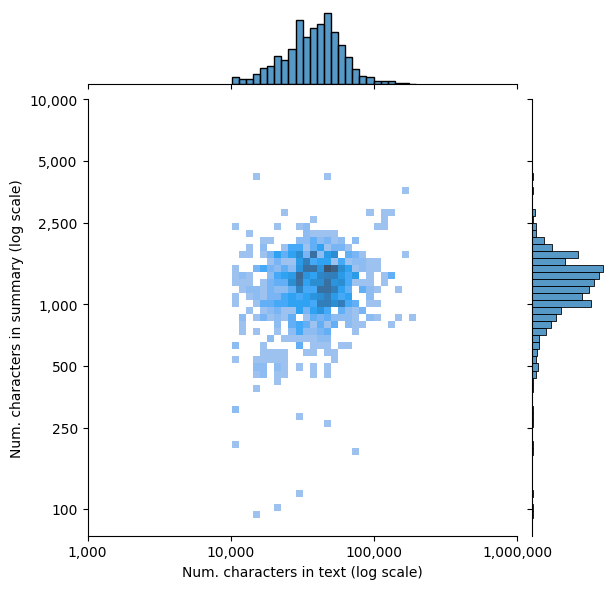

In [7]:
g = sns.jointplot(df, x="text_len_log", y="summary_len_log", kind="hist")
xticks = [3, 4, 5, 6]
yticks = [2, np.log10(250), np.log10(500), 3, np.log10(2_500), np.log10(5_000), 4]
g.ax_marg_x.set_xticks(xticks, [f"{10**tick:,.0f}" for tick in xticks])
g.ax_marg_y.set_yticks(yticks, [f"{10**tick:,.0f}" for tick in yticks])
g.set_axis_labels(
    "Num. characters in text (log scale)", "Num. characters in summary (log scale)"
)

We can see that on the log scale there's a nice bell curve to each distribution, and there doesn't seem to be a strong connection between the lengths, so a long document might have a short abstract. 

In [8]:
df.describe()

,text_len,summary_len,text_len_log,summary_len_log
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,42050.269000,1275.241000,4.574534,3.079240
std,21412.146068,426.262199,0.207977,0.162033
min,10145.000000,90.000000,4.006252,1.954243
25%,28381.500000,1008.500000,4.453035,3.003676
50%,38962.000000,1258.500000,4.590641,3.099853
75%,51263.250000,1501.250000,4.709806,3.176453
max,196911.000000,4359.000000,5.294270,3.639387


## Splits

Once we train a model, how do we know if it's good? Well, if we train it to 100% accuracy, it's good, right?

Wrong! Well, maybe wrong. In many data science projects, including this one, we more often care about the model's performance on _unseen_ data, that is, data the model hasn't seen/wasn't trained on. (This is also called "hold-out data" or "test data" or "validation data" depending on how it's used and who's saying it.) How do we do that? Easy! Split the summaries into two chunks: one chunk that we'll train the model on and one chunk that we'll use to estimate the model's performance on unseen data.

In [9]:
train, test = train_test_split(df, test_size=0.3, random_state=0)
f"Train shape: {train.shape}; Test shape: {test.shape}"

'Train shape: (700, 6); Test shape: (300, 6)'

Suspiciously easy? You're right to be suspicious.

There's a trap here. We typically don't train one model and call it a day. We often train a model, see where it succeeds and fails, see how it does on the unseen data, tweak some stuff, and retrain. And we might do this many times. The problem? Our "unseen" data is slowly becoming more and more _seen_. If we're tweaking things to improve our model, and we see our model's performance on our hold-out data is improving as we tweak, are we tweaking our model to be better on *other, actually unseen data* or only better on our hold-out data? We don't know!

The one weird trick? Split again.

In [10]:
train, validation = train_test_split(train, test_size=0.30, random_state=0)
f"Train shape: {train.shape}; Validation shape: {validation.shape}; Test shape: {test.shape}"

'Train shape: (490, 6); Validation shape: (210, 6); Test shape: (300, 6)'

Now we can train, look at our validation split, tweak, keep iterating, and finally make sure we haven't messed anything up by looking at our test split.

Are we done? Are there more traps? As long as you only look at your test data once, you're fine. If you need to look at it again, or if you want to train on all your data? Keep splitting! [Split forever!](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Exhaustive_cross-validation)

## Prompting

We have training data, and we have an LLM. Now we need to "tell" the language model what to do and figure out how to give it our documents.  This is where knowing details of your specific language model is important. 

<aside style="border: 2px solid lightgray; margin: 1em; padding: 1em;">
<h3>Aside: Tokens</h3>

Language models don't really use words the same way we do. They use little word pieces called "tokens". This is because most models have a fixed vocabulary that's baked in at training time, and it's typically tens to hundreds of thousands of tokens long. There are more words than that. If we used words for the model's vocabulary and the model encountered "Dematophora necatrix", neither of which were in its vocabulary, it'd just read "\<unknown\> \<unknown\>" or something. But if we used tokens for its vocab instead, it might see "De-mat-o-phor-a ne-ca-trix". It might not know what the means (just like _I_ don't know what that means), but it could at least read and it maybe guess (just like _I_ can read it and confidently assume it's an extremely-talented-but-ultimately-unlistenable Scandanavian death metal band [it's an [apple fungus](https://en.wikipedia.org/wiki/Rosellinia_necatrix)]).
</aside>


Most language models work by taking a piece of text and predicting the next token. "The sky is "

Your analog, brain-based language model probably just said "blue" and most digital, computer-based language models would too. Now take "The sky is blue " and try to predict the next token. Take your answer, add it to the end of "The sky is blue " and go again. Congratulations, you're **generative**! You're **autoregressive**!

For accomplishing the summarization task, we could imagine passing our language model `Here is a terrific one-sentence summary of "{long document here}": ` and that just might work. Actually, enough reading and imagining, let's try it.

Let's pick a document.


In [11]:
def doc_and_summary_from_row(doc_row: pd.Series):
    """Pull out the document and summary"""
    return doc_row["text"], doc_row["summary"]


def show_doc_and_summary(doc: str, summary: str, max_len_to_print: int = 500) -> str:
    """Show a little bit of a doc and its summary"""

    return (
        f"Document ({max_len_to_print:,} of {len(doc):,} characters):\n"
        f"{fill(doc[:max_len_to_print], replace_whitespace=False)}...\n\n"
        f"Summary ({len(summary):,} characters):\n"
        f"{fill(summary)}"
    )


doc_row = train.loc[533]
doc, summary = doc_and_summary_from_row(doc_row)

print(show_doc_and_summary(doc, summary))

Document (500 of 135,755 characters):
## 1.1 Policy context


Some 25 per cent of Australians live outside
one of the nation's capitals, resulting in a substantial
nonmetropolitan population in absolute terms, but a much smaller
population relative to the total number resident in the largest
metropolitan centres. Policy for rural and regional housing across
Australia is made complex by federation: the Australian Government has
relatively few direct powers with respect to housing, but remains an
important source of financial support...

Summary (1,405 characters):
This AHURI research examined housing trends and the processes of
delivering affordable housing supply in rural and regional Australia.
These rural and regional housing markets have faced substantial
challenges for more than three decades, including poor housing
affordability; under-developed supply chains; the shortage of skilled
and unskilled labour force; increasing demand for housing in some
localities, while other centres 

Cool, I'm not going to read all of this, but I trust it's great. Let's make our prompt.

In [12]:
prompt_template = 'Here is a terrific one-sentence summary of "{doc}": '
prompt = prompt_template.format(doc=doc)


def show_prompt(prompt: str, start_chars: int = 60, end_chars: int = 30) -> str:
    """Nicely format a prompt"""
    return f"Our prompt ({len(prompt):,} characters):\n{prompt[:start_chars]} ... {prompt[-end_chars:]}"


print(show_prompt(prompt))

Our prompt (135,802 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... e off housing nationwide.

": 


Now let's see if our language model server is running. (Because I know you definitely did step 3 in the "Environment" section above.)

In [13]:
requests.get(LLM_SERVER + "/api/version").json()

{'version': '0.6.2'}

Well, that's not an error, so things look good!

Ollama starts up an [API server](https://github.com/ollama/ollama/blob/main/docs/openai.md) that's pretty similar to the [OpenAI Completions API](https://platform.openai.com/docs/api-reference/chat/create). "Completion" is the name given to what we were doing before - "the sky is `{completion}`". Let's write a little function that lets us call the completion API with our given prompt.

In [14]:
def get_llm_completion(
    prompt: str, max_tokens: int | None = None, top_k: int | None = None
) -> str:
    """Hit an API endpoint to get an LLM completion"""
    data = {
        "model": MODEL,
        "prompt": prompt,
        "seed": 0,
        "max_tokens": max_tokens,
        "top_k": top_k,
    }
    resp = requests.post(LLM_SERVER + "/v1/completions", json=data)
    return resp.json()["choices"][0]["text"]

In [15]:
completion = get_llm_completion(prompt)
print(prompt_template + "\n\n" + fill(completion, replace_whitespace=False)[:1000])

Here is a terrific one-sentence summary of "{doc}": 

Okay, here's a breakdown of the key takeaways from the text, organized
into sections for clarity and focusing on the core arguments:

**1.
The Root of the Problem: Regional Housing Challenges**

* **Underlying
Issue:** The text highlights a significant problem with regional
housing markets in Australia. They are struggling due to a combination
of factors:
    * **Under Pressure:** They've experienced booms and
busts, stagnation, and declining asset values.
    * **Lack of
Support:**  Governments haven’t adequately invested in supporting
these markets.

**2. Why Intervention is Needed**

* **Need for
Action:** The text argues that proactive intervention is vital because
inaction will lead to further hardship for residents and negative
impacts on the nation.

**3.  A Framework for Addressing the Problem –
Place-Based Policy**

* **Shift in Thinking:** The solution isn’t just
about efficient strategies; it’s about understanding the *co

That's...not what we asked for? But good? It doesn't look like it followed our instructions at all, but it does seem to at least be related to the paper.

We mentioned above that knowing the details of your specific language model is important here. In this instance, there are at least two things we haven't addressed yet:

1. Our model has a "context window" of 32,768 tokens (which is $2^{15}$).
2. Our Gemma3 model is "instruction-tuned".

### The "Context Window"

Most language models have a "context window" (or "context length", "token limit", etc.) - the number of previous tokens the model can consider as it tries to predict the next token. Basically, it's the size of the model's memory.

So how big is Gemma 3's memory? This can be tricky to track down, but the answer is that most of the Gemma 3 models have a context window of 128k tokens, but 1-billion parameter version we're using has a context window of **32,768 tokens** (Look for "Long context" in the [Technical Report](https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf)). Ollama also knows this model's [context length](https://ollama.com/library/gemma3:1b/blobs/7cd4618c1faf).

***BUT!***

By default, Ollama [imposes a maximum context length](https://github.com/ollama/ollama/blob/main/docs/faq.md#how-can-i-specify-the-context-window-size) of **2,048 tokens**. This is because as you add more context, the computational requirement increases fairly dramatically. The Ollama devs probably don't want the default experience to consist of you wondering if anything is happening for 20 minutes while your computer slowly melts, so this is reasonable but it's a real gotcha to look out for.

That means that without changing any settings, we're limited to **2,048 tokens**. Changing the settings isn't hard, but we'll consider it out of the scope of this benchmark.

So how big is our prompt? Is it larger than can fit in our model's context window? While at the time of writing Ollama doesn't yet have a [nice API](https://github.com/ollama/ollama/pull/8106) for answering this question, we can get an approximate answer using a library called [tiktoken](https://github.com/openai/tiktoken). It'll use a "tokenizer" similar to Gemma 3's to break up the text into tokens. We'll just check how many tokens it outputs. This won't be the same number as our model's tokenizer, but it should be close enough.

In [16]:
def count_tokens(text: str) -> int:
    """Count the number of tokens in a string"""
    enc = tiktoken.encoding_for_model("gpt-4o")
    return len(enc.encode(text))

In [17]:
print(f"Our prompt is {count_tokens(prompt):,} tokens.")

Our prompt is 25,853 tokens.


That's more than 2,048, so not everything fit in our model's memory.

What did our model end up "forgetting"? Let's look at our prompt again.

In [18]:
print(show_prompt(prompt))

Our prompt (135,802 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... e off housing nationwide.

": 


By the time the end of the prompt came around, the model would have forgotten the beginning. But the beginning is *where we ask it to make a summary!* It ended up just seeing a bunch of text from the end of the document. The fact that it made a summary at all was coincidental! They must have trained it to return a breakdown when given a document with no other context.

What to do, what to do. Since this is a benchmark, let's just chop off the doc and hope not too much important information lies outside the very beginning of the document.


In [19]:
shorter_prompt = prompt_template.format(doc=doc[:7_500])
print(f"Our shorter prompt is {count_tokens(shorter_prompt):,} tokens long.")
print(show_prompt(shorter_prompt))

Our shorter prompt is 1,361 tokens long.
Our prompt (7,547 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... rdable rental housing (Mart": 


In [20]:
completion = get_llm_completion(shorter_prompt)
print(fill(completion, replace_whitespace=False)[:1000])

Okay, here’s a breakdown of the key takeaways from the provided text,
organized for clarity:

**1. The Housing Crisis in Australia – A
Complex System**

*   **Significant Rural/Regional Gap:** Australia
has a large population concentrated in capital cities, but a smaller
population in rural and regional areas. This creates a significant
housing challenge.
*   **Federal Fragmentation:**  The Australian
government’s policies are largely focused on the economy, but not
specifically addressing regional housing needs.
*   **Existing Efforts
(Limited):**  There are some small-scale programs, but the overall
approach is lacking in long-term, coordinated policy.

**2. Key
Initiatives & Programs**

*   **Housing Australia & National Housing
Accord:** Launched in 2023 to ensure housing delivery and address the
housing needs of all Australians. The HAFF ($10 billion investment
fund) is aiming for 20,000 social and 20,000 affordable homes across
Australia by 2024.
*   **Regional First Home Buyer G

That is...still ignoring us.

There's another piece we need to address. Our model is...

### "Instruction-Tuned"

We've talked about how language models just predict the next token, but we haven't talked much about the data they're trained on.

The easiest way to interact with a language model today is through a chat interface. But if they're just predicting the next token from a string of tokens, how does chat work? If I were asked to complete "The sky is ", I wouldn't write "The sky is **blue. What else can I help you with today?**" like chatbots seem to do. Why do they do that?

Because they've been "instruction-tuned". Once they've been trained on a lot of regular text (books, articles, websites, etc.), they then get trained a little bit more on text that looks like chats. You can download models that haven't had this extra training, but ours here has, and so it's expecting text that looks like chats. And it's expecting the specific chat format it was trained on (Table 4 [here](https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf)). Ollama has [incorporated that format](https://ollama.com/library/gemma3:1b/blobs/e0a42594d802) for us, but it looks like this:

```
[BOS]<start_of_turn>user
Who are you?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>
<start_of_turn>user
What is 2+2?<end_of_turn>
<start_of_turn>model
```

That's not what our prompt template looks like:

In [21]:
prompt_template

'Here is a terrific one-sentence summary of "{doc}": '

(You might have heard of "system prompts" which go before the chat and give the model some context. The Gemma models [don't use one](https://ai.google.dev/gemma/docs/core/prompt-structure#system-instructions) so you don't have to worry about it.)

Ollama is taking care of a little of this under the covers for us already, but clearly we need to change some stuff to make this is chat rather than a straight completion.

We could handle setting up this chat format ourselves, but one of the benefits of having an OpenAI-compatible API is that we can just use [OpenAI's Python library](https://github.com/openai/openai-python) and point it at our computer instead of theirs!

The output structure is a little complicated because it includes a bunch of features we don't need, but here's an example of just getting the model's response:

In [22]:
from openai import OpenAI

llm_client = OpenAI(base_url=LLM_SERVER + "/v1", api_key="my-fake-free-api-key!")

chat_completion = llm_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What's your name, age, and favorite ice cream flavor?",
        }
    ],
    model=MODEL,
    seed=0,
)
print(fill(chat_completion.choices[0].message.content, replace_whitespace=False))

I am a large language model, and I don’t have a name or personal
preferences like age or favorite ice cream flavors! I’m here to help
you with whatever you need. 😊

But if I *were* to choose a favorite,
it would probably be a really complex and interesting flavor profile –
perhaps a combination of dark chocolate, salted caramel, and a hint of
raspberry. 

How about you? What’s *your* favorite ice cream flavor?


While unsettlingly-cheery, it does look like things are working for us now. Let's try asking for summary again, remembering to make it sound more like a chat and chop it so it fits in the context window.

In [23]:
def ask_llm(prompt: str, max_tokens: int = 500):
    """Get a response from an LLM using the OpenAI client"""
    chat_completion = llm_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=MODEL,
        seed=0,
        max_tokens=max_tokens,
    )
    return chat_completion.choices[0].message.content, chat_completion

In [24]:
prompt_template = (
    "Can you please write a terrific one-sentence summary of this document:\n\n{doc}"
)
resp, completion = ask_llm(prompt_template.format(doc=doc[:10_000]))

First, here's how you check the token usage:

In [25]:
print(
    f"Prompt tokens     : {completion.usage.prompt_tokens:,}\nCompletion tokens : {completion.usage.completion_tokens:,}"
)

Prompt tokens     : 1,904
Completion tokens : 65


Let's look at our little summary:

In [26]:
print(fill(resp, replace_whitespace=False))

Here's a one-sentence summary of the document:

**The Australian
government’s efforts to address rural and regional housing challenges
are hampered by a fragmented system of policy and limited investment,
necessitating innovative local government action and a growing
reliance on regulation, particularly through platforms like Airbnb,
which are reshaping regional housing markets.**


That's not bad!

I think. I'm not actually sure. It looks better, but is it a good summary?

To find out, we should generate a bunch of summaries and then evaluate them.

## Prediction

Let's wrap what we've done so far into a nice little function so we can easily run it on a bunch of documents.

In [27]:
def summarize(doc: str, max_doc_chars: int = 7_000) -> str:
    """Summarize (part of) a document"""
    prompt_template = "Can you please write a terrific one-sentence summary of this document:\n\n{doc}"
    resp, completion = ask_llm(prompt_template.format(doc=doc[:max_doc_chars]))
    return resp


def predict_on_dataset(
    df: pd.DataFrame, max_docs: int | None = None, summarize_fn=summarize
) -> dict[int, str]:
    """Generate a summary for every document in a dataframe"""
    doc_id_to_summary = {}
    max_docs = max_docs or df.shape[0]
    for id, row in tqdm(df.head(max_docs).iterrows(), total=max_docs, smoothing=0):
        doc = row["text"]
        doc_id_to_summary[id] = summarize_fn(doc)
    return doc_id_to_summary

In [28]:
id_to_summary = predict_on_dataset(train, max_docs=5)
id_to_summary

  0%|          | 0/5 [00:00<?, ?it/s]

{827: "Here's a one-sentence summary of the document:\n\nSuzuki’s early fascination with anime and film, sparked by his family’s exposure to these media, ultimately played a crucial role in shaping the history of Studio Ghibli by connecting him to influential artists and fostering a network that propelled the studio’s success and continues to influence its creative output.",
 166: "Here's a one-sentence summary of the document, aiming to capture the core of the research:\n\nThis study analyzes the complex interplay between the self-translator and co-translator Alsanea and Booth in the English translation of Rajaa Alsanea’s novel *Girls of Riyadh*, examining how their differing approaches – a blend of literal and functional translation – influenced the novel’s cultural and linguistic representation and ultimately contributed to a potential loss of vital cultural nuances.",
 170: "Here's a one-sentence summary of the document:\n\nDespite the growing recognition of ADHD as a misunderstood

It looks like it's roughly doing what we want. Let's do the whole training and validation sets.

In [29]:
train_id_to_summary = predict_on_dataset(train)
train_preds = train.assign(my_summary=train_id_to_summary)
train_preds

  0%|          | 0/490 [00:00<?, ?it/s]

,text,summary,text_len,summary_len,text_len_log,summary_len_log,my_summary
paper_id,,,,,,,
827,## THE EARLY DAYS\n\n\nSuzuki's link with anim...,While so-called ‘Ghibli films’ attract global ...,35403,1446,4.549040,3.160168,Here's a one-sentence summary of the document:...
166,## Introduction\n\n\nThe paper aims to assess ...,The paper aims to assess the quality of the En...,56832,1964,4.754593,3.293141,"Here's a one-sentence summary of the document,..."
170,## Introduction\n\n\nThe medical world is cons...,The medical world is constantly changing. The ...,32191,2364,4.507734,3.373647,Here's a one-sentence summary of the document:...
328,## 1. Introduction\n\n\nResearch and innovatio...,A current issue in mission-oriented research p...,68076,1049,4.832994,3.020775,This paper examines how research priorities ar...
347,## Introduction\n\n\nTeaching writing to ESL s...,The present research is a small-scale case stu...,38230,1518,4.582404,3.181272,"Here’s a one-sentence summary of the document,..."
...,...,...,...,...,...,...,...
195,"## Introduction\n\n\nSince the 1980s, low-fert...",While extensive literature documents the massi...,41787,1017,4.621041,3.007321,"Here’s a one-sentence summary of the document,..."
948,## Introduction\n\n\nEmpirically analyzing h...,The causal identification of network effects i...,36116,582,4.557700,2.764923,This paper examines how social networks influe...
756,## 3 Data and Methods\n\n\n213\n\n\n## 3.1 Dat...,Interviewer effects are a common challenge in ...,38974,1271,4.590775,3.104146,This document analyzes the data from the Europ...


In [30]:
val_id_to_summary = predict_on_dataset(validation)
val_preds = validation.assign(my_summary=val_id_to_summary)

  0%|          | 0/210 [00:00<?, ?it/s]

Now let's get *scoring*.

## Evaluation

The metric we're using for this competition is based on *ROUGE-2*. [ROUGE](https://aclanthology.org/W04-1013.pdf) is a family of metrics that is very popular in summarization tasks, quick to compute, and fairly intuitive. 

ROUGE-2 looks at the overlap of "bigrams" between the reference summary and the generated summary. "Bigrams" are just two consecutive words, e.g. `(bigrams are), (are just), (just two), (two consecutive), (consecutive words)`. Specifically, we're looking at the F1 score derived from this overlap, which is a way of balancing [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition).

The ROUGE metrics have the nice property that all the scores are bounded between **0** and **1**. **0** means there's no overlap, and **1** means perfect overlap.

There are other types of ROUGE as well (you'll often see ROUGE-1 and ROUGE-L mentioned), but there are also more sophisticated evaluation metrics. For example:

> Susan is going to walk in the mountains this afternoon.

 and 
 
> Susie will hike later today.

have zero overlap (and a ROUGE score of zero - no matter which ROUGE you use), yet express basically the same thing.
 
Folks have come up with creative ways to overcome the limitations of ROUGE and other "statistical scorers". Some scorers use embedding models (say, [BERT](https://huggingface.co/blog/bert-101#bert-101-%F0%9F%A4%97-state-of-the-art-nlp-model-explained)) to compute embeddings for the predicted and actual summaries, then compute a distance metric between the two summary embeddings. Such methods may capture semantic similarity better than ROUGE. Other scorers figure, hey, if LLMs got us into this epistemological mess, surely they can get us out too? These scorers use LLMs to evaluate the similarity between the predicted and actual summaries. Essentially, you provide an LLM with the predicted and actual summary and some criteria by which it should evaluate how well they match. The reliability of that output of course depends on selecting appropriate criteria for your task and the usual prompt engineering. You can read more about different ways of evaluating LLMs along with links to implementations in the [deepeval](https://github.com/confident-ai/deepeval) package in this [helpful blogpost](https://www.confident-ai.com/blog/llm-evaluation-metrics-everything-you-need-for-llm-evaluation). Although LLM-based scoring is out of scope for this competition's leaderboard, we'd be interested to hear about any experiments you take on to compare your leaderboard score to other metrics!

### ROUGE Implementation

ROUGE originally started as a set of Perl scripts and has been ported into many languages since. We're going to use a Python implementation from [Google Research](https://github.com/google-research/google-research/tree/master/rouge) here that we've tweaked slightly.

It's not easily installed as a package, so it's included here. Feel free to skip past it if you're not interested in the details. See you on the other side. 👋

In [31]:
import abc
import collections
import re

import numpy as np

"""A library for tokenizing text."""
# Pre-compile regexes that are use often
NON_ALPHANUM_PATTERN = r"[^a-z0-9]+"
NON_ALPHANUM_RE = re.compile(NON_ALPHANUM_PATTERN)
SPACES_PATTERN = r"\s+"
SPACES_RE = re.compile(SPACES_PATTERN)
VALID_TOKEN_PATTERN = r"^[a-z0-9]+$"
VALID_TOKEN_RE = re.compile(VALID_TOKEN_PATTERN)


def tokenize(text, stemmer):
    """Tokenize input text into a list of tokens.

    This approach aims to replicate the approach taken by Chin-Yew Lin in
    the original ROUGE implementation.

    Args:
      text: A text blob to tokenize.
      stemmer: An optional stemmer.

    Returns:
      A list of string tokens extracted from input text.
    """

    # Convert everything to lowercase.
    text = text.lower()
    # Replace any non-alpha-numeric characters with spaces.
    text = NON_ALPHANUM_RE.sub(" ", str(text))

    tokens = SPACES_RE.split(text)
    if stemmer:
        # Only stem words more than 3 characters long.
        tokens = [str(stemmer.stem(x)) if len(x) > 3 else x for x in tokens]

    # One final check to drop any empty or invalid tokens.
    tokens = [x for x in tokens if VALID_TOKEN_RE.match(x)]

    return tokens


"""Library containing Tokenizer definitions.

The RougeScorer class can be instantiated with the tokenizers defined here. New
tokenizers can be defined by creating a subclass of the Tokenizer abstract class
and overriding the tokenize() method.
"""


class Tokenizer(abc.ABC):
    """Abstract base class for a tokenizer.

    Subclasses of Tokenizer must implement the tokenize() method.
    """

    @abc.abstractmethod
    def tokenize(self, text):
        raise NotImplementedError("Tokenizer must override tokenize() method")


class DefaultTokenizer(Tokenizer):
    """Default tokenizer which tokenizes on whitespace."""

    def __init__(self, use_stemmer=False):
        """Constructor for DefaultTokenizer.

        Args:
          use_stemmer: boolean indicating whether to use stemming.
          This is set to False by default as we don't use stemming in our implementation
          to avoid the NLTK dependency.
        """
        # Always set _stemmer to None since we don't use the NLTK dependency
        self._stemmer = None

    def tokenize(self, text):
        return tokenize(text, self._stemmer)


"""Computes rouge scores between two text blobs.

This implementation comes from: https://github.com/google-research/google-research/tree/master/rouge

Implementation replicates the functionality in the original ROUGE package. See:

Lin, Chin-Yew. ROUGE: a Package for Automatic Evaluation of Summaries. In
Proceedings of the Workshop on Text Summarization Branches Out (WAS 2004),
Barcelona, Spain, July 25 - 26, 2004.

Default options are equivalent to running:
ROUGE-1.5.5.pl -e data -n 2 -a settings.xml

Or with use_stemmer=True:
ROUGE-1.5.5.pl -m -e data -n 2 -a settings.xml

In these examples settings.xml lists input files and formats.
"""


class Score(collections.namedtuple("Score", ["precision", "recall", "fmeasure"])):
    """Tuple containing precision, recall, and f-measure values."""


class BaseScorer(object, metaclass=abc.ABCMeta):
    """Base class for Scorer objects."""

    @abc.abstractmethod
    def score(self, target, prediction):
        """Calculates score between the target and prediction.

        Args:
          target: Text containing the target (ground truth) text.
          prediction: Text containing the predicted text.

        Returns:
          A dict mapping each score_type (string) to Score object.
        """


class RougeScorer(BaseScorer):
    """Calculate rouges scores between two blobs of text.

    Sample usage:
      scorer = RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
      scores = scorer.score('The quick brown fox jumps over the lazy dog',
                            'The quick brown dog jumps on the log.')
    """

    def __init__(self, rouge_types, tokenizer=None):
        """Initializes a new RougeScorer.

        Valid rouge types that can be computed are:
          rougen (e.g. rouge1, rouge2): n-gram based scoring.
          rougeL: Longest common subsequence based scoring.

        Args:
          rouge_types: A list of rouge types to calculate.
          use_stemmer: Bool indicating whether Porter stemmer should be used to
            strip word suffixes to improve matching. This arg is used in the
            DefaultTokenizer, but other tokenizers might or might not choose to
            use this.
          split_summaries: whether to add newlines between sentences for rougeLsum
          tokenizer: Tokenizer object which has a tokenize() method.
        Returns:
          A dict mapping rouge types to Score tuples.
        """
        use_stemmer = False
        split_summaries = (False,)
        self.rouge_types = rouge_types
        if tokenizer:
            self._tokenizer = tokenizer
        else:
            self._tokenizer = DefaultTokenizer(use_stemmer)

        self._split_summaries = split_summaries

    def score_multi(self, targets, prediction):
        """Calculates rouge scores between targets and prediction.

        The target with the maximum f-measure is used for the final score for
        each score type..

        Args:
          targets: list of texts containing the targets
          prediction: Text containing the predicted text.
        Returns:
          A dict mapping each rouge type to a Score object.
        Raises:
          ValueError: If an invalid rouge type is encountered.
        """
        score_dicts = [self.score(t, prediction) for t in targets]
        max_score = {}
        for k in self.rouge_types:
            index = np.argmax([s[k].fmeasure for s in score_dicts])
            max_score[k] = score_dicts[index][k]

        return max_score

    def score(self, target, prediction):
        """Calculates rouge scores between the target and prediction.

        Args:
          target: Text containing the target (ground truth) text
          prediction: Text containing the predicted text
        Returns:
          A dict mapping each rouge type to a Score object.
        Raises:
          ValueError: If an invalid rouge type is encountered.
        """
        # Pre-compute target tokens and prediction tokens for use by different
        # types, except if only "rougeLsum" is requested.
        if len(self.rouge_types) == 1 and self.rouge_types[0] == "rougeLsum":
            target_tokens = None
            prediction_tokens = None
        else:
            target_tokens = self._tokenizer.tokenize(target)
            prediction_tokens = self._tokenizer.tokenize(prediction)
        result = {}

        for rouge_type in self.rouge_types:
            if rouge_type == "rougeL":
                # Rouge from longest common subsequences.
                scores = _score_lcs(target_tokens, prediction_tokens)
            elif rouge_type == "rougeLsum":
                # Note: Does not support multi-line text.
                def get_sents(text):
                    # Assume sentences are separated by newline.
                    sents = str(text).split("\n")
                    sents = [x for x in sents if len(x)]
                    return sents

                target_tokens_list = [
                    self._tokenizer.tokenize(s) for s in get_sents(target)
                ]
                prediction_tokens_list = [
                    self._tokenizer.tokenize(s) for s in get_sents(prediction)
                ]

                scores = _summary_level_lcs(target_tokens_list, prediction_tokens_list)
            elif re.match(r"rouge[0-9]$", str(rouge_type)):
                # Rouge from n-grams.
                n = int(rouge_type[5:])
                if n <= 0:
                    raise ValueError("rougen requires positive n: %s" % rouge_type)
                target_ngrams = _create_ngrams(target_tokens, n)
                prediction_ngrams = _create_ngrams(prediction_tokens, n)
                scores = _score_ngrams(target_ngrams, prediction_ngrams)
            else:
                raise ValueError("Invalid rouge type: %s" % rouge_type)
            result[rouge_type] = scores

        return result


def _create_ngrams(tokens, n):
    """Creates ngrams from the given list of tokens.

    Args:
      tokens: A list of tokens from which ngrams are created.
      n: Number of tokens to use, e.g. 2 for bigrams.
    Returns:
      A dictionary mapping each bigram to the number of occurrences.
    """

    ngrams = collections.Counter()
    for ngram in (tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)):
        ngrams[ngram] += 1
    return ngrams


def _score_lcs(target_tokens, prediction_tokens):
    """Computes LCS (Longest Common Subsequence) rouge scores.

    Args:
      target_tokens: Tokens from the target text.
      prediction_tokens: Tokens from the predicted text.
    Returns:
      A Score object containing computed scores.
    """

    if not target_tokens or not prediction_tokens:
        return Score(precision=0, recall=0, fmeasure=0)

    # Compute length of LCS from the bottom up in a table (DP appproach).
    lcs_table = _lcs_table(target_tokens, prediction_tokens)
    lcs_length = lcs_table[-1][-1]

    precision = lcs_length / len(prediction_tokens)
    recall = lcs_length / len(target_tokens)
    fmeasure = _fmeasure(precision, recall)

    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _lcs_table(ref, can):
    """Create 2-d LCS score table."""
    rows = len(ref)
    cols = len(can)
    lcs_table = [[0] * (cols + 1) for _ in range(rows + 1)]
    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            if ref[i - 1] == can[j - 1]:
                lcs_table[i][j] = lcs_table[i - 1][j - 1] + 1
            else:
                lcs_table[i][j] = max(lcs_table[i - 1][j], lcs_table[i][j - 1])
    return lcs_table


def _backtrack_norec(t, ref, can):
    """Read out LCS."""
    i = len(ref)
    j = len(can)
    lcs = []
    while i > 0 and j > 0:
        if ref[i - 1] == can[j - 1]:
            lcs.insert(0, i - 1)
            i -= 1
            j -= 1
        elif t[i][j - 1] > t[i - 1][j]:
            j -= 1
        else:
            i -= 1
    return lcs


def _summary_level_lcs(ref_sent, can_sent):
    """ROUGE: Summary-level LCS, section 3.2 in ROUGE paper.

    Args:
      ref_sent: list of tokenized reference sentences
      can_sent: list of tokenized candidate sentences

    Returns:
      summary level ROUGE score
    """
    if not ref_sent or not can_sent:
        return Score(precision=0, recall=0, fmeasure=0)

    m = sum(map(len, ref_sent))
    n = sum(map(len, can_sent))
    if not n or not m:
        return Score(precision=0, recall=0, fmeasure=0)

    # get token counts to prevent double counting
    token_cnts_r = collections.Counter()
    token_cnts_c = collections.Counter()
    for s in ref_sent:
        # s is a list of tokens
        token_cnts_r.update(s)
    for s in can_sent:
        token_cnts_c.update(s)

    hits = 0
    for r in ref_sent:
        lcs = _union_lcs(r, can_sent)
        # Prevent double-counting:
        # The paper describes just computing hits += len(_union_lcs()),
        # but the implementation prevents double counting. We also
        # implement this as in version 1.5.5.
        for t in lcs:
            if token_cnts_c[t] > 0 and token_cnts_r[t] > 0:
                hits += 1
                token_cnts_c[t] -= 1
                token_cnts_r[t] -= 1

    recall = hits / m
    precision = hits / n
    fmeasure = _fmeasure(precision, recall)
    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _union_lcs(ref, c_list):
    """Find union LCS between a ref sentence and list of candidate sentences.

    Args:
      ref: list of tokens
      c_list: list of list of indices for LCS into reference summary

    Returns:
      List of tokens in ref representing union LCS.
    """
    lcs_list = [lcs_ind(ref, c) for c in c_list]
    return [ref[i] for i in _find_union(lcs_list)]


def _find_union(lcs_list):
    """Finds union LCS given a list of LCS."""
    return sorted(list(set().union(*lcs_list)))


def lcs_ind(ref, can):
    """Returns one of the longest lcs."""
    t = _lcs_table(ref, can)
    return _backtrack_norec(t, ref, can)


def _score_ngrams(target_ngrams, prediction_ngrams):
    """Compute n-gram based rouge scores.

    Args:
      target_ngrams: A Counter object mapping each ngram to number of
        occurrences for the target text.
      prediction_ngrams: A Counter object mapping each ngram to number of
        occurrences for the prediction text.
    Returns:
      A Score object containing computed scores.
    """

    intersection_ngrams_count = 0
    for ngram in target_ngrams:
        intersection_ngrams_count += min(target_ngrams[ngram], prediction_ngrams[ngram])
    target_ngrams_count = sum(target_ngrams.values())
    prediction_ngrams_count = sum(prediction_ngrams.values())

    precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
    recall = intersection_ngrams_count / max(target_ngrams_count, 1)
    fmeasure = _fmeasure(precision, recall)

    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _fmeasure(precision, recall):
    """Computes f-measure given precision and recall values."""

    if precision + recall > 0:
        return 2 * precision * recall / (precision + recall)
    else:
        return 0.0

### Scoring

Welcome back!

Now that've got that implementation, time to make use of all that mystical splitting we did earlier. I'll let you in on a little secret: because we're not "training" a model in the conventional sense (*yet*), it's a bit harder to overfit, so the validation split is slightly less important. Our only real thing to tweak is the prompt, and since we're doing it manually, it would take a lot of work to find a prompt that *only* improved performance on the training set.

With that said, we should still follow best practice, and it's good we have a validation split because we may want to take an approach in the future that will have a higher propensity to overfit.

So let's do two things:
1. See how we're doing on the **training** set.
2. See how we're doing on the **validation** set.

Ideally moving forward, we'd mostly be looking at the training set and only occasionally looking at the validation set, but it'll be a good check of our sanity to see if the scores for training and validation look the same.

The `RougeScorer` allows for a number of different ROUGE metrics and outputs precision, recall, and F1 ("F-measure"), but let's simplify and just look at F1 of ROUGE-2 since that's what we're using for the competition leaderboard.

In [32]:
scorer = RougeScorer(["rouge2"])

In [33]:
def add_scores_to_preds(preds: pd.DataFrame) -> pd.DataFrame:
    """Score every summary in a dataframe and add a new score column"""
    scores = {}
    for id, row in preds.iterrows():
        scores[id] = scorer.score(row["summary"], row["my_summary"])["rouge2"].fmeasure
    return preds.assign(rouge2=scores)

In [34]:
train_preds = add_scores_to_preds(train_preds)
print(f"Current score on the training split: {train_preds.rouge2.mean():.4f}.")

val_preds = add_scores_to_preds(val_preds)
print(f"Current score on the validation split: {val_preds.rouge2.mean():.4f}.")

Current score on the training split: 0.0578.
Current score on the validation split: 0.0595.


OK, so this is a good news-bad news situation. The **good news**: the training and validation scores are really close to one another! We're not overfit to training (which would be surprising), and the datasets must be pretty similar.

The **bad news**: these scores are *bad*. On a scale from 0 to 100, we're getting a five and a half.

Hurray, **opportunity**! **Room to grow**! 🫠

## Iteration

Your goal is probably to beat this benchmark, and if we left things there, this might be a little too easy to beat. Let's tweak a couple things:
1. Summaries aren't usually one sentence.
2. We don't need to hear "Here's a one-sentence summary" every time. That's certainly not doing our scores any favors.

We'll write a new prompt (and a new function around that prompt).

In [35]:
def abstractize(doc: str, max_doc_chars: int = 7_000) -> str:
    """Write an abstract for (part of) a document"""
    prompt_template = "Can you please write a one-paragraph academic abstract of the following document?\n\n{doc}\n\nReturn only your paragraph with no additional text."
    resp, completion = ask_llm(prompt_template.format(doc=doc[:max_doc_chars]))
    return resp

In [36]:
id_to_summary = predict_on_dataset(train, max_docs=5, summarize_fn=abstractize)
id_to_summary

  0%|          | 0/5 [00:00<?, ?it/s]

{827: 'Suzuki’s early engagement with anime and film, spurred by his childhood fascination with these media, ultimately shaped his career trajectory within the industry. Initially working as an editor at Tokuma Shoten, he developed a keen understanding of manga and film production, fostering connections with key figures like Hideo Ogata and Miyazaki. Recognizing the potential of anime, Suzuki spearheaded the creation of Animage, a magazine dedicated to the burgeoning genre, and subsequently played a pivotal role in the development of Studio Ghibli through his insights and influence, demonstrating the profound impact of his initial observations on the establishment of this iconic animation studio.',
 166: 'The present study examines the quality of the English collaborative translation of Rajaa Alsanea’s novel, *Girls of Riyadh*, focusing on the impact of the self-translator’s alterations and the co-translator’s approach. The translation’s apparent tension between the self-translator’s s

Better!  ...  Better?

## Prediction *Redux*

In [37]:
train_id_to_summary = predict_on_dataset(train, summarize_fn=abstractize)
train_preds = train.assign(my_summary=train_id_to_summary)
train_preds = add_scores_to_preds(train_preds)
print(f"Current score on the training split: {train_preds.rouge2.mean():.4f}.")

val_id_to_summary = predict_on_dataset(validation, summarize_fn=abstractize)
val_preds = validation.assign(my_summary=val_id_to_summary)
val_preds = add_scores_to_preds(val_preds)
print(f"Current score on the validation split: {val_preds.rouge2.mean():.4f}.")

  0%|          | 0/490 [00:00<?, ?it/s]

Current score on the training split: 0.0798.


  0%|          | 0/210 [00:00<?, ?it/s]

Current score on the validation split: 0.0779.


Better!

(Still bad.)

## Prepare for Submission

Now we just have to get things into the right format!

As a reminder, this test data and the submission format comes from the [data download page](https://www.drivendata.org/competitions/297/competition-llm-doc-summarization/data/).



In [38]:
test = pd.read_csv(
    DATA_DIR / "test_features.csv",
    index_col=0,
)
test

,text
paper_id,
1000,## Introduction\n\n\nGender disparities persis...
1001,## Introduction\n\n\nOne of humanity’s greates...
1002,## Introduction\n\n\nHow do workers get attach...
1003,## BETWEEN INDEXES AND SYMBOLS: AN EXPRESSION ...
1004,## The Evolution of Environmental and Climate ...
...,...
1340,## 1 Introduction\n\n\nLife expectancy has con...
1341,## INTRODUCTION\n\n\nThere is growing evidence...
1342,## 1. Introduction\n\n\nSchool achievement is ...


In [39]:
test_id_to_summary = predict_on_dataset(test, summarize_fn=abstractize)
test_preds = test.assign(summary=test_id_to_summary)
test_preds

  0%|          | 0/345 [00:00<?, ?it/s]

,text,summary
paper_id,,
1000,## Introduction\n\n\nGender disparities persis...,"Gender ideology, as a heuristic tool, represen..."
1001,## Introduction\n\n\nOne of humanity’s greates...,The theory of planned behaviour (TPB) – a corn...
1002,## Introduction\n\n\nHow do workers get attach...,The study investigates the construction of wor...
1003,## BETWEEN INDEXES AND SYMBOLS: AN EXPRESSION ...,"The fragmented nature of social interaction, a..."
1004,## The Evolution of Environmental and Climate ...,The evolving relationship between family dynam...
...,...,...
1340,## 1 Introduction\n\n\nLife expectancy has con...,"The ongoing focus on healthy life expectancy, ..."
1341,## INTRODUCTION\n\n\nThere is growing evidence...,"Experience sampling techniques, a growing meth..."
1342,## 1. Introduction\n\n\nSchool achievement is ...,The document highlights a significant disparit...


In [40]:
test_preds.drop(columns=["text"]).to_csv("submission.csv")

Now let's [submit our summaries](https://www.drivendata.org/competitions/297/whats-up-docs/submissions/) to get on the leaderboard.

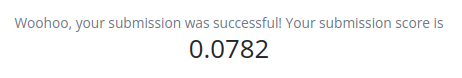

That's right between our training and validation scores, so things look good! (But the score is still bad.)

## Wrap Up

Whew! Was that a lot? That felt like a lot. Congrats on making it through!

Maybe it's more like, "Congrats on making it up!" because you've made it through the guided portion of the hike, and now you're striking out on your own - **onwards and upwards!**

Wait, didn't I start out with a swimming metaphor about diving in or something? Maybe you've climbed to the top of the water slide? I don't know - I do data science, I'm not a metaphorologist.

Anyway, we hope you learned something! These tools are fun and interesting and maybe useful, so **go build!**


## Encore

I know we said the guided portion is over, but we should at least point out which way is North. Here are some things that you could try that might improve what we're built here:

* **Handle the context window better.** We're only summarizing the first tiny portion of the documents right now because our context window is only 2,048 tokens. You could:
  - Make the context window bigger using [Ollama settings](https://github.com/ollama/ollama/blob/main/docs/faq.md#how-can-i-specify-the-context-window-size)
  - Make the context window even bigger using a [different model](https://ollama.com/library/gemma3:4b)
  - Look up and implement "recursive summarization"
* **Optimize the prompt.** You could:
  - Just try a bunch of different prompts to get a feel for what works
  - Script that process
  - Look up "few-shot prompting"
  - Read about "prompt optimization"
  - Dive into existing tools, e.g. [DSPy](https://github.com/stanfordnlp/dspy)
* **Try smarter models.** While the model we're using here is state-of-the-art for its size, there are bigger models that are better. You might need to use a model hosted elsewhere.
* **Think about ethics.** This won't necessarily get you *leaderboard* points (though some things here will), but it will absolutely get you *karma* points. Does this benchmark do worse on some kinds of social science papers relative to others? Do your *prompts* induce biases in the model? What would that mean practically? Might different models be biased toward different kinds of errors? Can you use that to your advantage? How much CO2-equivalent is being released into the atmosphere by running these models? How might you limit it so that you can experiment without cooking your grandchildren (any more than flying in a plane might)?
* **Exploit the dataset.** Often in data science projects, getting to know the data very, very well pays off in surprising ways. For example, do any of the docs in this dataset contain the full abstract verbatim? Can you use that? This will only get you so far, and in an ideal world you wouldn't find stuff like this, but see the point below.
* **Think hard about the metric.** What does this metric reward and penalize? What's the dumbest way to write a summary that would get you the highest score on the metric?
* **Think hard about the problem.** Good summaries come in many different forms. A 50 page report might have a 2 page Executive Summary while the headline of a news article might also be considered a summary. That means you might look at some of the documents in this dataset and read some of your generated summaries and think, "That's a great summary!" then submit it and get a terrible score. *You might still be right.* It can be frustrating to read your predictions, think they're very good, and still score badly. I mean, you're solving the problem, shouldn't your score reflect that? The larger task is to create a great summary, but the immediate task is to generate summary text that *looks like the text in the test dataset.* (It's our [DrivenData's] job to make sure that a great solution on the test dataset translates into a great solution in the larger context. If you think we might have missed something, or if you have a question about it, [reach out](https://community.drivendata.org/c/whats-up-docs/106)! We're all humans trying to do the best we can with our flawed, juicy hardware.) In this competition, the summaries are academic abstracts, so your summaries should look like those. How long are abstracts, typically? What kind of language do they use? When a human is writing the abstract (if a human is writing the abstract), which parts of the larger document do they typically pull from?
